# Preprocess and window longitudinal datasets and save afterwards

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.insert(0, '/home/jovyan/braindecode/')
import pickle

In [3]:
from decode_tueg import (
    get_longitudinal_ds, preprocess, get_preprocessors,
    _create_windows, _create_final_scores, load_exp,
    get_n_preds_per_input, DataScaler, TargetScaler,
    Augmenter, iter_exp_dir,
)

Tue Feb 14 15:16:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.48.07    Driver Version: 515.48.07    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:3E:00.0 Off |                  N/A |
| 27%   26C    P8     9W / 250W |      1MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
exp_date = '2023-02-09T09:34:21.685021'
exp_dir = '/home/jovyan/experiments/'
mapping = None  # where to get this from?
checkpoint = 'train_end'

In [5]:
for x in iter_exp_dir(exp_dir, exp_date):
    break

In [6]:
estimator, data_scaler, target_scaler, config = load_exp(
    exp_dir, os.path.join(exp_dir, x), checkpoint)

In [7]:
min_age = int(config.min_age)
max_age = int(config.max_age)
tmin = int(config.tmin)
tmax = int(config.tmax)
n_jobs = int(config.n_jobs)
window_size_samples = int(config.window_size_samples)
preload = int(config.preload)
target_name = config.target_name
out_dir = config.out_dir

In [12]:
#'pathological', 'non_pathological', 'transition'
for ds_name in ['pathological', 'non_pathological', 'transition']:
    print(f'getting {ds_name}')
    ds = get_longitudinal_ds(ds_name, (min_age, max_age))
    print('preprocessing')
    ds = preprocess(
        ds, 
        preprocessors=get_preprocessors(tmin, tmax), 
        n_jobs=n_jobs,
    )
    n_preds_per_input = get_n_preds_per_input(
        estimator.module, ds[0][0].shape[0], window_size_samples)
    print('windowing')
    ds = _create_windows(
        ds,
        window_size_samples,
        n_jobs, 
        preload,
        n_preds_per_input,
        mapping,
    )
    with open(f'/home/jovyan/longitudinal/{ds_name}_pre_win.pkl', 'wb') as f:
        pickle.dump(ds, f)

getting
preprocessing
2023-02-14 12:24:39 DEBUG    adding cropper 60 – None
2023-02-14 12:26:26 DEBUG    model produces 5504 preds for every input of size 6000
windowing
getting
preprocessing
2023-02-14 13:09:17 DEBUG    adding cropper 60 – None
2023-02-14 13:09:37 DEBUG    model produces 5504 preds for every input of size 6000
windowing
getting
preprocessing
2023-02-14 13:15:41 DEBUG    adding cropper 60 – None
2023-02-14 13:15:58 DEBUG    model produces 5504 preds for every input of size 6000
windowing


In [7]:
print("hiu")

hiu


# Predict the longitudinal datasets

In [1]:
import os
import sys
sys.path.insert(0, '/home/jovyan/braindecode/')
import pickle

In [2]:
import numpy as np
import pandas as pd

In [3]:
from decode_tueg import (
    deconfound, load_exp, _create_final_scores, plot_age_gap_hist, plot_heatmaps,
    save_csv, plot_age_gap_hist_and_permutation_test, DataScaler, TargetScaler,
    Augmenter, iter_exp_dir,
)

Fri Feb 17 10:43:00 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.48.07    Driver Version: 515.48.07    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:3D:00.0 Off |                  N/A |
| 27%   27C    P8    12W / 250W |      1MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
exp_dir = '/home/jovyan/experiments/'
exp_date = '2023-02-15T18:43:26.819382'
checkpoint = 'train_end'

In [5]:
n_recordings = None
save = True

In [ ]:
# read all experiment models (seeds and cv / eval runs) to predict longitudinal datasets
# 'transition', 'non_pathological', 'pathological'
for ds_name in ['pathological']:
    for exp_path in iter_exp_dir(exp_dir, exp_date):
        print(f'loading exp {exp_path}')
        estimator, data_scaler, target_scaler, config = load_exp(
            exp_dir, exp_path, checkpoint)
        print(f'getting {ds_name}')
        with open(f'/home/jovyan/longitudinal/{ds_name}_pre_win.pkl', 'rb') as f:
            ds = pickle.load(f)
        if n_recordings not in [-1, None]:
            ds = ds.split(list(range(n_recordings)))['0']
        print('predicting')
        ds_preds, ds_score = _create_final_scores(
            estimator,
            ds,
            ds_name,
            config.target_name,
            target_scaler,
            data_scaler,
            int(config.n_jobs),
            subject_wise=True,
            mem_efficient=ds_name in ['pathological'],
        )
        # write preds to file
        if save:
            save_path = os.path.join(exp_dir, exp_path, 'preds')
            print(f'saving {save_path}')
            save_csv(
                ds_preds,
                save_path,
                f'{checkpoint}_longitudinal_{ds_name}_preds.csv',
            )
            # write scores to file
            scores = pd.read_csv(
                os.path.join(os.path.join(exp_dir, exp_path), f'{checkpoint}_scores.csv'), 
                index_col=0,
            )
            for k, v in ds_score.items():
                scores[k] = v
            save_csv(
                scores,
                os.path.join(exp_dir, exp_path),
                f'{checkpoint}_scores.csv',
            )

loading exp 2023-02-15T18:43:26.819382/20230214/0
getting pathological
predicting
2023-02-17 10:43:25 INFO     on pathological reached
2023-02-17 10:43:25 DEBUG    0/4585
2023-02-17 10:47:35 DEBUG    100/4585
2023-02-17 10:51:32 DEBUG    200/4585
2023-02-17 10:56:00 DEBUG    300/4585
2023-02-17 11:01:18 DEBUG    400/4585
2023-02-17 11:05:41 DEBUG    500/4585
2023-02-17 11:09:30 DEBUG    600/4585
2023-02-17 11:13:52 DEBUG    700/4585
2023-02-17 11:18:08 DEBUG    800/4585
2023-02-17 11:22:32 DEBUG    900/4585
2023-02-17 11:26:57 DEBUG    1000/4585
2023-02-17 11:31:24 DEBUG    1100/4585
2023-02-17 11:36:36 DEBUG    1200/4585
2023-02-17 11:41:16 DEBUG    1300/4585
2023-02-17 11:46:14 DEBUG    1400/4585
2023-02-17 11:50:26 DEBUG    1500/4585
2023-02-17 11:54:30 DEBUG    1600/4585
2023-02-17 11:58:29 DEBUG    1700/4585
2023-02-17 12:02:32 DEBUG    1800/4585
2023-02-17 12:07:10 DEBUG    1900/4585
2023-02-17 12:12:06 DEBUG    2000/4585
2023-02-17 12:16:43 DEBUG    2100/4585
2023-02-17 12:20:48

In [ ]:
print("hi")

In [ ]:
datasets

# Read the longitudinal predictions and plot them

In [1]:
import os
import sys
sys.path.insert(0, '/home/jovyan/braindecode/')

In [2]:
import pandas as pd

In [3]:
from decode_tueg import (
    deconfound, plot_age_gap_hist, plot_heatmaps,
    plot_age_gap_hist_and_permutation_test, iter_exp_dir,
    deconfound,
)

Wed Feb 22 10:42:36 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.48.07    Driver Version: 515.48.07    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:B1:00.0 Off |                  N/A |
| 49%   58C    P2   231W / 250W |   4936MiB / 11264MiB |     93%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
exp_dir = '/home/jovyan/experiments/'
exp_date = '2023-02-15T18:43:26.819382'
checkpoint = 'train_end'

In [5]:
bin_width = 2
n_repetitions = 1000  # actually 100000!
detrend = None#'quadratic'

In [6]:
if n_repetitions != 100000:
    print("WARNING! Wrong number of reps!")

WARNING! Wrong number of reps!


In [7]:
subject_wise = True

observed age gap diff 0.7439456616594684


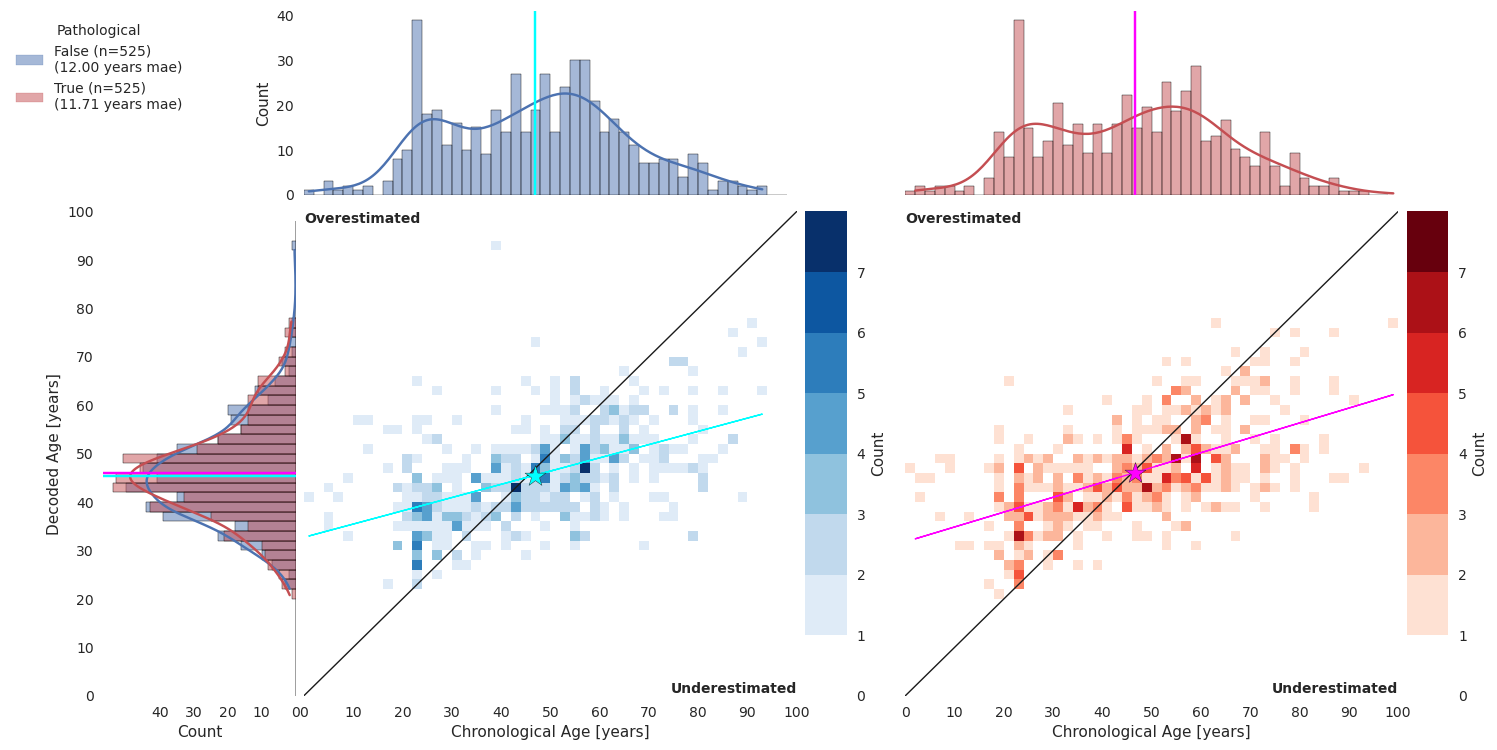

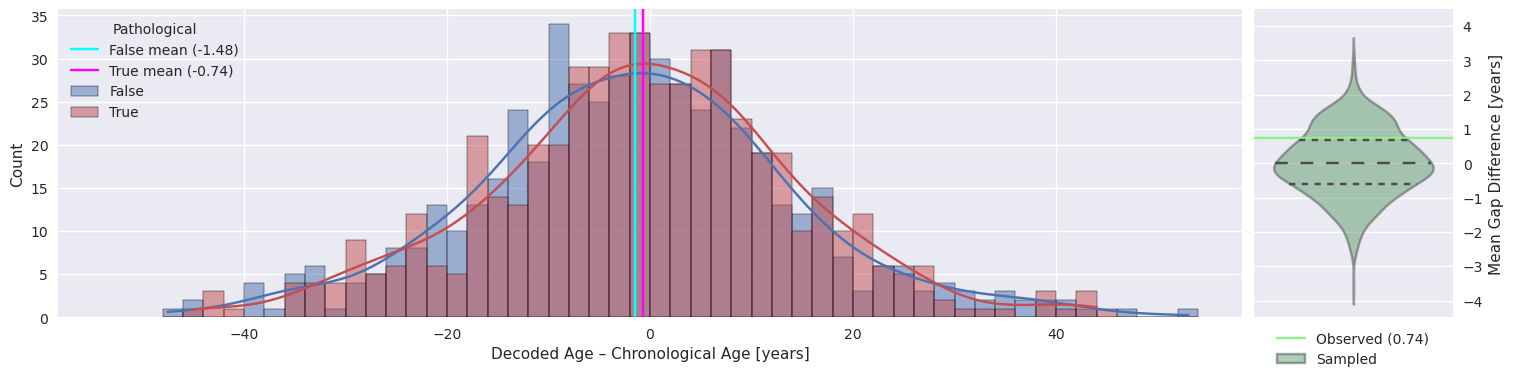

In [8]:
cols = ['y_true', 'y_pred', 'subject', 'pathological']
for ds_name in ['transition']:#, 'non_pathological', 'pathological']:
    all_preds, configs = [], []
    for i, exp_path in enumerate(iter_exp_dir(exp_dir, exp_date)):
        preds_path = os.path.join(exp_dir, exp_path, 'preds', f'{checkpoint}_longitudinal_{ds_name}_preds.csv')
        try:
            preds = pd.read_csv(preds_path, index_col=0)[cols]
        except:
            continue
        all_preds.append(preds)
    all_preds = pd.concat(all_preds)
    all_preds = all_preds.reset_index().groupby('index').mean().reset_index(drop=True)

    if subject_wise:
        all_preds = all_preds.groupby(['pathological', 'subject'], as_index=False).mean()
    
    plot_heatmaps(all_preds, bin_width)
    # possible to deconfound here?
    if detrend is not None:
        all_preds = deconfound(all_preds, detrend)
    if ds_name == 'transition':
        plot_age_gap_hist_and_permutation_test(all_preds, bin_width, n_repetitions)
    else:
        plot_age_gap_hist(all_preds, bin_width)

In [9]:
# TODO: compute patient level gaps and difference, not population level

In [10]:
import seaborn as sns

In [11]:
import matplotlib.pyplot as plt

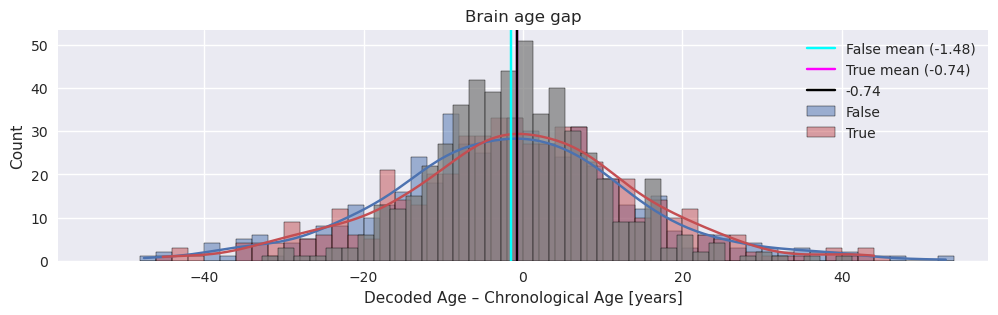

In [82]:
ax = plot_age_gap_hist(all_preds, bin_width)

subject_wise_gaps = []
for s, g in all_preds.groupby('subject'):
    gap = (g.y_pred - g.y_true)[::-1].diff().tail(1)
    subject_wise_gaps.append(gap)
subject_wise_gaps = pd.concat(subject_wise_gaps)

#fig, ax = plt.subplots(1, 1, figsize=(12,3))
ax = sns.histplot(subject_wise_gaps, ax=ax, color='grey', binwidth=bin_width)
#ax = sns.histplot(data=all_preds, x=gap, hue='pathological', ax=ax)
ax.axvline(subject_wise_gaps.mean(), c='black', label=f'{subject_wise_gaps.mean():.2f}')
ax.legend()

In [15]:
from decode_tueg import reject_derivating_ages

In [16]:
for ds_i, ds_ in enumerate(ds.datasets):
    break

In [18]:
_ = [ds_.set_description(
    {'path': ds_.description['path'].replace(
        '/data/datasets/TUH/EEG/tuh_eeg', '/home/jovyan/mne_data/TUH/tuh_eeg/')},
    overwrite=True,
) for ds_i, ds_ in enumerate(ds.datasets)]